In [2]:
import collections
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [3]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

In [5]:
def tokenizer(text):
    return text.split()

In [6]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

In [7]:
max_length = 256
train_data = train_data.map(tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length})
test_data = test_data.map(tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length})

Map: 100%|██████████| 25000/25000 [00:00<00:00, 28070.93 examples/s]


In [8]:
test_size = 0.25
train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]


In [10]:
counter = collections.Counter()
for example in train_data["tokens"]:
    counter.update(example)

min_freq = 5
vocab = {word: i + 2 for i, (word, freq) in enumerate(counter.items()) if freq >= min_freq}
special_tokens = ["<unk>", "<pad>"]
vocab.update({token: i for i, token in enumerate(special_tokens)})


In [11]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [12]:
def numericalize_example(example, vocab):
    ids = [vocab.get(token, unk_index) for token in example["tokens"]]
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})


Map: 100%|██████████| 25000/25000 [00:03<00:00, 6500.80 examples/s]


In [13]:
train_data.set_format(type="torch", columns=["ids", "label"])
valid_data.set_format(type="torch", columns=["ids", "label"])
test_data.set_format(type="torch", columns=["ids", "label"])

In [14]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [torch.tensor(i["ids"]) for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = torch.tensor([i["label"] for i in batch])
        batch = {"ids": batch_ids, "label": batch_label}
        return batch
    return collate_fn


In [15]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

batch_size = 512
train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)


In [16]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(embedding_dim, n_filters, filter_size)
                for filter_size in filter_sizes
            ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        embedded = self.dropout(self.embedding(ids))
        embedded = embedded.permute(0, 2, 1)
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [conv.max(dim=-1).values for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        prediction = self.fc(cat)
        return prediction


In [17]:
dropout_rate = 0.25
output_dim = len(train_data.unique("label"))
filter_sizes = [3, 5, 7]
n_filters = 100
embedding_dim = 300
vocab_size = len(vocab)


In [18]:
model = CNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    n_filters=n_filters,
    filter_sizes=filter_sizes,
    output_dim=output_dim,
    dropout_rate=dropout_rate,
    pad_index=pad_index,
)


In [19]:
n_epochs = 3
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [20]:
def train_model(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        predictions = model(batch["ids"])
        loss = criterion(predictions, batch["label"])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            predictions = model(batch["ids"])
            loss = criterion(predictions, batch["label"])
            total_loss += loss.item()
    return total_loss / len(data_loader)


In [ ]:
train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_loss = train_model(model, train_data_loader, optimizer, criterion)
    valid_loss = evaluate_model(model, valid_data_loader, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

  0%|          | 0/37 [00:00<?, ?it/s]

/var/folders/fp/q0m5t1y91ds296s1c7f_6w1c0000gn/T/ipykernel_72114/3812657777.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_ids = [torch.tensor(i["ids"]) for i in batch]
  0%|          | 0/37 [00:00<?, ?it/s]


IndexError: index out of range in self

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

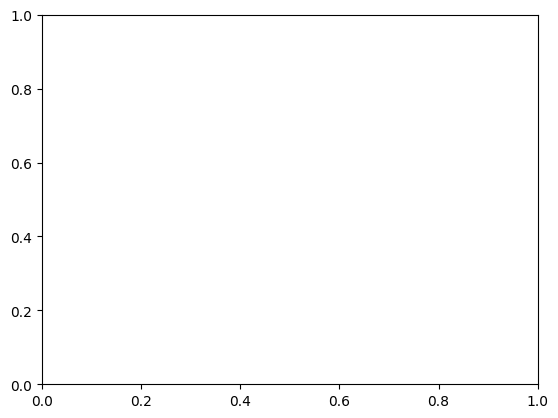

In [ ]:
plt.plot(range(1, n_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, n_epochs+1), valid_losses, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()